<a href="https://colab.research.google.com/github/vaclavkratochvil/Consistency-independent-AHP-Alternative/blob/main/AHP_alternative_for_incosistent_cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supplementary Material for **Multi-Criteria Decision Making Beyond Consistency: An Alternative to AHP for Real-World Industrial Problems**

This Jupyter Notebook contains the supplementary material for the paper *Carpitella, Silvia, Václav Kratochvíl, and Miroslav Pištěk. "Multi-criteria decision making beyond consistency: An alternative to AHP for real-world industrial problems." Computers & Industrial Engineering (2024): 110661. [https://doi.org/10.1016/j.cie.2024.110661](https://doi.org/10.1016/j.cie.2024.110661)*

This document includes the source code and several examples demonstrating the usage and results discussed in the paper.


**!! To run the code online, open it in [Google Colab](https://colab.research.google.com/github/vaclavkratochvil/AHP/blob/main/AHP_alternative_for_incosistent_cases.ipynb) !!**

The paper generalizes concepts from our recent publication:
> *Carpitella Silvia, Inuiguchi Masahiro, Kratochvíl Václav, Pištěk Miroslav :  Multi-criteria decision analysis without consistency in pairwise comparisons , Computers & Industrial Engineering vol.168, 2022. [10.1016/j.cie.2022.108089](https://doi.org/10.1016/j.cie.2022.108089)*





In [ ]:
%pip install pycddlib-standalone

## Aggregated Preference Matrix
The aggregated preference matrix is a composite matrix derived from multiple pairwise comparison matrices (PCMs) and a vector of weights that signify the relative importance of each PCM. Each reciprocal PCM $R^{(i)}$ is weighted by $w_i$​ from the weight vector $w$. The aggregated preference matrix is computed using the element-wise geometric mean of the weighted PCMs, ensuring that the results remains reciprocal. This process is crucial for combining evaluations across different criteria or experts into a single, coherent PCM for decision-making. For a precise definition, see equation (3) in refered paper.

In [2]:
import numpy as np

def aggregated_preference_matrix(R_list, w):
    """
    Compute the aggregated preference matrix using element-wise weighted geometric mean.

    Parameters:
    R_list (list of np.ndarray): List of pairwise comparison matrices as NumPy arrays.
    w (np.ndarray): Weight vector.

    Returns:
    np.ndarray: Aggregated preference matrix.
    """
    # Ensure the number of matrices matches the number of weights
    if len(R_list) != len(w):
        raise ValueError("The number of matrices and weights must be the same.")

    # Compute the element-wise weighted geometric mean
    weighted_geom_mean = np.ones_like(R_list[0])
    for matrix, weight in zip(R_list, w):
        weighted_geom_mean *= np.power(matrix, weight)

    return weighted_geom_mean

# Define a helper function to print matrices or vectors with row and column names
def print_named_matrix_or_vector(matrix_or_vector, row_names, col_names=None):
    if col_names is None:  # It's a vector
        # Determine the maximum length of the names for proper alignment
        max_name_length = max(len(name) for name in row_names)

        # Print the vector
        for row_name, val in zip(row_names, matrix_or_vector):
            print(f"{row_name:>{max_name_length}}: {val:.4f}")
    else:  # It's a matrix
        # Determine the maximum length of the names for proper alignment
        max_name_length = max(max(len(name) for name in row_names), max(len(name) for name in col_names))

        # Print the column headers
        print(" " * (max_name_length + 1), end="")
        for name in col_names:
            print(f"{name:>{max_name_length}}", end=" ")
        print()

        # Print each row with its name
        for row_name, row in zip(row_names, matrix_or_vector):
            print(f"{row_name:>{max_name_length}}", end=" ")
            for val in row:
                print(f"{val:>{max_name_length}.4f}", end=" ")
            print()
        print()

## The canonical weight vector
The canonical weight vector is determined through a process that begins with a
reciprocal pairwise comparison matrix (PCM). By taking the element-wise logarithm of the PCM, a skew-symmetric matrix is obtained. This matrix allows the formulation of a system of linear inequalities that identifies all maximal preferred elements based on the Subjective Stochastic Dominance (SSB) representation. To address any
potential non-uniqueness among these elements, the optimal distribution of preference
is defined as the unique maximal preferred element that maximizes entropy. This optimal
distribution represents the most balanced and unbiased allocation of preferences.

The canonical weight vector is then derived by taking the normalized inverse of the
vector resulting from multiplying the transpose of the reciprocal PCM by the optimal
distribution of preference. This vector reflects the relative scores of individual
alternatives, ensuring a coherent and consistent representation of preferences. For a
consistent PCM, the canonical weight vector aligns with the weight vector used in the
Analytic Hierarchy Process (AHP). This approach ensures that the derived weight vector
accurately represents the underlying preferences and priorities, even in the presence
of inconsistencies within the PCM.

In the following code, we provide two alternative methods to achieve a maximum-entropy
solution. The first approach is based on the [scipy](https://docs.scipy.org/doc/scipy/tutorial/optimize.html) package, which we find may be more prone to numerical errors. The second approach uses the [cdd](https://pycddlib.readthedocs.io) package, which lacks direct support for optimization. Fortunatelly, the respective polyhedron usually collapse to one point. If not, then we rely on the fact that a uniform probability distribution has maximal entropy. If the corresponding probability polyhedron has two extreme points representing degenerate probability distributions with a single non-zero probability,
then the maximum entropy point will lie on the edge between these extremes, precisely at their midpoint. Similarly if we have more points representing e.g. a facet.

The functions are based on equations (4), (5), and (6) in the referenced paper.

In [29]:
import numpy as np
import cdd
from scipy.optimize import minimize

def m_tilde_cdd(X):
    """
    Identifies the optimal distribution of preferences within a given pairwise
    comparison matrix X by maximizing entropy using the cddlib library.

    The function constructs a convex polyhedron from X in H-representation
    (half-space representation) and converts it to V-representation to obtain
    the extreme points. The optimal distribution is calculated by averaging
    the extreme points, yielding hopefully to a solution that corresponds to
    a point with maximal entropy on the polyhedron.

    Parameters:
    X (numpy.ndarray): Pairwise comparison matrix with preferences.

    Returns:
    numpy.ndarray: The optimal distribution of preferences maximizing entropy.
    """
    #  Step 1: Create skew-symmetric matrix X by applying element-wise logarithm
    num_vars = X.shape[1]

    # Step 2: Create convex polyhedron in H-representation (half-space representation)
    # 0 <= b1 + a1 * x
    # 0 == b2 + a2 * x (for sum of probabilities constraint)

    # Creating inequality constraints from X: a1 * x <= b1 (in this case, b1 = 0)
    a1 = -X
    b1 = np.zeros((num_vars, 1))

    # Creating equality constraint: sum of preferences equal to 1
    a2 = -np.ones((1, num_vars))
    b2 = np.array([[1]])

    # Creating inequality constraints: non-negativity of preferences
    a3 = np.eye(num_vars)
    b3 = np.zeros((num_vars, 1))

    # Combine constraints for H-representation
    h_matrix = np.vstack((np.hstack((b1, a1)), np.hstack((b2, a2)), np.hstack((b3, a3))))

    # Convert to the required format for cddlib
    M = cdd.matrix_from_array(h_matrix, lin_set = {num_vars}, rep_type=cdd.RepType.INEQUALITY)

    # Convert H-representation to V-representation (vertices representation)
    poly = cdd.polyhedron_from_matrix(M)
    V = cdd.copy_generators(poly)

    # Extract the extreme points of the polyhedron
    vertices = np.array([v[1:] for v in V.array if v[0] == 1])

    # In case of more extreme points, return their combination, which corresponds
    # to minimal Shannon-entropy point on the polyhedron
    return np.mean(vertices, axis=0)

def m_tilde_scipy(X):
    """
    Identifies the optimal distribution of preferences within a given pairwise
    comparison matrix X by maximizing entropy using the scipy library.

    The function defines Shannon entropy as the objective function to maximize
    and uses the scipy.optimize.minimize function to find the distribution
    that maximizes entropy. It includes constraints to ensure the sum of
    preferences equals one, preferences are non-negative, and follows
    subjective stochastic dominance (SSB).

    Parameters:
    X (numpy.ndarray): Pairwise comparison matrix with preferences.

    Returns:
    numpy.ndarray: The optimal distribution of preferences maximizing entropy.
    """

    # Shannon entropy as the objective function for minimization
    def shannon_entropy_point(point):
        probabilities = point / np.sum(point)
        entropy = -np.sum(probabilities * np.log(probabilities + 1e-9))  # Adding a small number to avoid log(0)
        return entropy

    # Automatically generate an initial point using the Dirichlet distribution
    def generate_initial_point(dimensions):
        return np.random.dirichlet(np.ones(dimensions))

    # Determine the number of dimensions from matrix X
    num_dimensions = X.shape[1]

    # Generate a valid initial point
    initial_point = generate_initial_point(num_dimensions)

    # Constraints for SSB maximal element
    constraints = [
        {'type': 'ineq', 'fun': lambda m: -np.dot(X, m)},  # Xm <= 0
        {'type': 'eq', 'fun': lambda m: np.sum(m) - 1},    # m1 + m2 + m3 + ... = 1
        {'type': 'ineq', 'fun': lambda m: m}               # m >= 0 (non-negative)
    ]

    # Find the maximum element (note the negative sign to maximize entropy)
    result = minimize(lambda m: -shannon_entropy_point(m), initial_point, constraints=constraints, bounds=[(0, None)] * num_dimensions)

    # Result
    return result.x

def kappa(R, method = "cdd"):
    """
    Compute the canonical weight vector \kappa(R) for reciprocal matrix R.

    Parameters:
    R (numpy.ndarray): Input reciprocal matrix.
    method (string): cdd or scipy to determine which approach will be used

    Returns:
    numpy.ndarray: weight vector of preferences.
    """
    # Step 1: Create SSB matrix X
    X = np.log(R)

    # Step 2: Find the minimum entropy point m_tilde - choose one of the methods
    if(method == "cdd"):
      m_tilde = m_tilde_cdd(X)
    else:
      m_tilde = m_tilde_scipy(X)

    # Step 3: Calculate vector pi
    pi = np.dot(R.T, m_tilde)

    # Step 4: Normalize vector 1/pi
    inv_pi = 1 / pi
    normalized_inv_pi = inv_pi / np.sum(inv_pi)

    return normalized_inv_pi

## Consistency independent Decision Technique
Given a multi-criteria decision-making problem encoded in AHP-like format. I.e Matrix $A$ represents the pairwise comparison matrix for the criteria relative to the goal. Each matrix in the list $B$ represents the pairwise comparison of alternatives with respect to each criterion.

Our consistency independent technique is the following:
1. Given reciprocal matrix $A$ we calculate the cannonical weight vector $\kappa(A)$
2. The obtained vector is used as a weight to aggregate matrices $B$ using the (weighted) geometric mean, thus obtaining aggregated preference matrix $B^{\kappa(A)}$
3. Such a matrix is again reciprocal, we may evaluate the vector of final weights $z_{CI}$ as $κ(B^{\kappa(A)})$






## Leader example
To demonstrate the typical problem, let's consider a decision-making scenario by [Wikipedia](https://w.wiki/AUJZ) involving three alternatives and four criteria. This can be exemplified using a scenario called "Tom, Dick, and Harry," which is based on a real-world situation of selecting a new leader for a company facing the retirement of its founder. In this example, there are three potential candidates for the leadership role - **Tom**, **Dick**, and **Harry** - and they are assessed based on four different criteria: **Age**, **Charisma**, **Education**, and **Experience**. The problem involves comparing these criteria in pairs and recording the preferences in a matrix form.

The example is discussed in **Section 4.3.1** in the referred paper.

First, we will define the pairwise comparison matrices for Experience, Education, Charisma, and Age, as well as the criteria comparison matrix.

In [4]:
import numpy as np

# Leader names
leader_names = ["Tom", "Dick", "Harry"]

# Pairwise comparison matrix for Experience
experience = np.array([
    [1, 1/4, 4],
    [4, 1, 9],
    [1/4, 1/9, 1]
])
print("Experience:")
print_named_matrix_or_vector(experience, leader_names, leader_names)

# Pairwise comparison matrix for Education
education = np.array([
    [1, 3, 1/5],
    [1/3, 1, 1/7],
    [5, 7, 1]
])
print("Education:")
print_named_matrix_or_vector(education, leader_names, leader_names)

# Pairwise comparison matrix for Charisma
charisma = np.array([
    [1, 5, 9],
    [1/5, 1, 4],
    [1/9, 1/4, 1]
])
print("Charisma:")
print_named_matrix_or_vector(charisma, leader_names, leader_names)

# Pairwise comparison matrix for Age
age = np.array([
    [1, 1/3, 5],
    [3, 1, 9],
    [1/5, 1/9, 1]
])
print("Age:")
print_named_matrix_or_vector(age, leader_names, leader_names)

# List of pairwise comparison matrices
B_list = [experience, education, charisma, age]

# Criteria comparison matrix
criteria_names = ["Experience", "Education", "Charisma", "Age"]
criteria = np.array([
    [1, 4, 3, 7],
    [1/4, 1, 1/3, 3],
    [1/3, 3, 1, 5],
    [1/7, 1/3, 1/5, 1]
])
print("Criteria:")
print_named_matrix_or_vector(criteria, criteria_names, criteria_names)

Experience:
        Tom  Dick Harry 
  Tom 1.0000 0.2500 4.0000 
 Dick 4.0000 1.0000 9.0000 
Harry 0.2500 0.1111 1.0000 

Education:
        Tom  Dick Harry 
  Tom 1.0000 3.0000 0.2000 
 Dick 0.3333 1.0000 0.1429 
Harry 5.0000 7.0000 1.0000 

Charisma:
        Tom  Dick Harry 
  Tom 1.0000 5.0000 9.0000 
 Dick 0.2000 1.0000 4.0000 
Harry 0.1111 0.2500 1.0000 

Age:
        Tom  Dick Harry 
  Tom 1.0000 0.3333 5.0000 
 Dick 3.0000 1.0000 9.0000 
Harry 0.2000 0.1111 1.0000 

Criteria:
           Experience  Education   Charisma        Age 
Experience     1.0000     4.0000     3.0000     7.0000 
 Education     0.2500     1.0000     0.3333     3.0000 
  Charisma     0.3333     3.0000     1.0000     5.0000 
       Age     0.1429     0.3333     0.2000     1.0000 



### Consistency-independent Decision Technique


In [5]:
# Compute the cannonical weight vector for the criteria matrix using the kappa function
criteria_weights = kappa(criteria)

# Compute the aggregated preference matrix
aggregated_matrix = aggregated_preference_matrix(B_list, criteria_weights)

print("Aggregated Preference Matrix:")
print_named_matrix_or_vector(aggregated_matrix, leader_names, leader_names)

# Compute the final weights using the kappa function
final_weights = kappa(aggregated_matrix)

# Rank the candidates based on their overall scores
ranked_candidates = sorted(zip(leader_names, final_weights), key=lambda x: x[1], reverse=True)

# Display the final rankings
print("\nCI Ranking of Candidates:")
for rank, (candidate, score) in enumerate(ranked_candidates, 1):
    print(f"{rank}. {candidate} with score: {score:.4f}")

Aggregated Preference Matrix:
        Tom  Dick Harry 
  Tom 1.0000 0.6543 3.0879 
 Dick 1.5282 1.0000 4.2232 
Harry 0.3238 0.2368 1.0000 


CI Ranking of Candidates:
1. Dick with score: 0.5288
2. Tom with score: 0.3460
3. Harry with score: 0.1252


### AHP - comparison

In [6]:
import numpy as np

# Function to convert matrix B into a weight vector
def convertToWeights(B):
    # Normalize the columns of matrix B
    Bnorm = B / B.sum(axis=0)

    # Return the mean of each row (average across columns)
    return np.mean(Bnorm, axis=1)

# lB2S: Convert a list of matrices (lB) into weight vectors by applying convertToWeights
def lB2S(lB):
    # Apply the convertToWeights function on each matrix in the list lB
    return np.array([convertToWeights(B) for B in lB])

# A2w: Calculate the weight vector from matrix A using eigenvectors
def A2w(A):
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(A)

    # Take the absolute value of the first eigenvector
    w = np.abs(eigenvectors[:, 0])

    # Normalize the weight vector so that the sum is 1
    w = w / np.sum(w)

    # Return the weight vector
    return w

# solve_AHP: Main function for AHP that computes the result from matrix A and list of matrices lB
def solve_AHP(A, lB, leader_names, criteria_names):
    # Convert the list of matrices (lB) into a matrix of weights (S)
    S = lB2S(lB)

    # Calculate the weight vector from the criteria matrix A
    w = A2w(A)

    # Multiply matrix S by the weight vector w
    v = np.dot(S.T, w)

    return v

In [7]:
# Solve AHP using the criteria and the list of pairwise comparison matrices
overall_scores = solve_AHP(criteria, B_list, leader_names, criteria_names)

# Rank the candidates based on their overall scores
ranked_candidates = sorted(zip(leader_names, overall_scores), key=lambda x: x[1], reverse=True)

# Display the final rankings
print("\nAHP Ranking of Candidates:")
for rank, (candidate, score) in enumerate(ranked_candidates, 1):
    print(f"{rank}. {candidate} with score: {score:.4f}")


AHP Ranking of Candidates:
1. Dick with score: 0.4923
2. Tom with score: 0.3583
3. Harry with score: 0.1494


###BWM (Best-Worst Method) - comparison
Best-Worst Method (BWM) simplifies the process by requiring fewer comparisons than AHP. It asks the decision-maker to identify the best and worst criteria and compare them with others.

**How it works:**

*     You first select the best and worst criteria.
*    Then, you compare the best criterion against all others, and similarly, the worst criterion against all others.
*    A mathematical optimization problem is solved to derive the optimal weight vector that minimizes inconsistencies.


In [11]:
import numpy as np
from scipy.optimize import linprog

# Function to perform the Best-Worst Method (BWM)
def best_worst_method(best_to_others, worst_to_others):
    """
    Perform Best-Worst Method (BWM) calculation.

    Parameters:
    best_to_others (list): Comparison values of the best criterion against all others.
    worst_to_others (list): Comparison values of all other criteria against the worst criterion.

    Returns:
    np.ndarray: The weight vector.
    """
    n = len(best_to_others)

    # Create the linear programming setup for solving BWM
    c = [0] * n + [1]  # Objective function (minimize the maximum absolute deviation)
    A_ub = []
    b_ub = []

    # Add constraints for best-to-others comparisons
    for i in range(n):
        row = [0] * n
        row[i] = 1
        row.append(-1)
        A_ub.append(row)
        b_ub.append(best_to_others[i])

    # Add constraints for worst-to-others comparisons
    for i in range(n):
        row = [0] * n
        row[i] = -1
        row.append(-1)
        A_ub.append(row)
        b_ub.append(-worst_to_others[i])

    # Bounds for the decision variables (weights must be non-negative)
    bounds = [(0, None)] * n + [(None, None)]

    # Solve using linear programming
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

    # The weight vector is in the solution
    return res.x[:-1] / np.sum(res.x[:-1])  # Normalize the weights

# Function to compute the geometric mean of rows in a matrix (GMM)
def geometric_mean_method(matrix):
    """
    Compute the geometric mean of each row in the pairwise comparison matrix.

    Parameters:
    matrix (numpy.ndarray): The pairwise comparison matrix.

    Returns:
    numpy.ndarray: The normalized priority vector (weights for each candidate).
    """
    geometric_mean = np.prod(matrix, axis=1) ** (1 / matrix.shape[1])
    return geometric_mean / np.sum(geometric_mean)


# Compute weights (priority vectors) for each criterion using Geometric Mean Method (GMM)
experience_weights = geometric_mean_method(experience)
education_weights = geometric_mean_method(education)
charisma_weights = geometric_mean_method(charisma)
age_weights = geometric_mean_method(age)

# Combine the weights into a decision matrix (candidates x criteria)
decision_matrix = np.column_stack([experience_weights, education_weights, charisma_weights, age_weights])

# Identify the best and worst criteria based on the criteria weights
best_criterion_index = np.argmax(criteria_weights)
worst_criterion_index = np.argmin(criteria_weights)

best_criterion = criteria[best_criterion_index]
worst_criterion = criteria[:, worst_criterion_index]

print(f"\nBest criterion: {criteria_names[best_criterion_index]}")
print(f"Worst criterion: {criteria_names[worst_criterion_index]}")

# Perform BWM using the best-to-others and worst-to-others comparisons
bwm_weights = best_worst_method(best_criterion, worst_criterion)

# Apply the BWM weights to the candidates' decision matrix to compute final scores
final_scores = np.dot(decision_matrix, bwm_weights)

# Rank the candidates based on their final scores
ranked_candidates = sorted(zip(leader_names, final_scores), key=lambda x: x[1], reverse=True)

# Display the final rankings
print("\nFinal Ranking of Candidates (Using BWM):")
for rank, (candidate, score) in enumerate(ranked_candidates, 1):
    print(f"{rank}. {candidate} with score: {score:.4f}")



Best criterion: Experience
Worst criterion: Age

Final Ranking of Candidates (Using BWM):
1. Dick with score: 0.5427
2. Tom with score: 0.3924
3. Harry with score: 0.0649


###TOPSIS (Technique for Order Preference by Similarity to Ideal Solution) - comparison

TOPSIS is a widely used method for multi-criteria decision analysis (MCDA). It ranks alternatives based on the distance from an ideal solution and a negative-ideal solution.

**How it works:**
* You compute the distance of each alternative to an ideal best solution (which has the best performance in all criteria) and the distance to the ideal worst solution.
* The alternative closest to the ideal best solution and farthest from the worst solution is ranked highest.

In [12]:
import numpy as np

# Define which criteria are benefit criteria (True for benefit, False for cost)
benefit_criteria = [True, True, True, True]

# Function to normalize the decision matrix
def normalize_matrix(matrix):
    norm = np.sqrt(np.sum(matrix ** 2, axis=0))
    return matrix / norm

# Function to perform TOPSIS
def topsis(decision_matrix, weights, benefit_criteria):
    normalized_matrix = normalize_matrix(decision_matrix)
    weighted_matrix = normalized_matrix * weights
    ideal_solution = np.max(weighted_matrix, axis=0)
    anti_ideal_solution = np.min(weighted_matrix, axis=0)
    distance_to_ideal = np.sqrt(np.sum((weighted_matrix - ideal_solution) ** 2, axis=1))
    distance_to_anti_ideal = np.sqrt(np.sum((weighted_matrix - anti_ideal_solution) ** 2, axis=1))
    relative_closeness = distance_to_anti_ideal / (distance_to_ideal + distance_to_anti_ideal)
    return relative_closeness

# Perform TOPSIS on the computed decision matrix
topsis_scores = topsis(decision_matrix, criteria_weights, benefit_criteria)

# Rank the candidates based on the TOPSIS scores
ranked_candidates = sorted(zip(leader_names, topsis_scores), key=lambda x: x[1], reverse=True)

# Display the final rankings
print("\nTOPSIS Ranking of Candidates:")
for rank, (candidate, score) in enumerate(ranked_candidates, 1):
    print(f"{rank}. {candidate} with score: {score:.4f}")



TOPSIS Ranking of Candidates:
1. Dick with score: 0.7326
2. Tom with score: 0.3421
3. Harry with score: 0.1883


### PROMETHEE (Preference Ranking Organization METHod for Enrichment Evaluations) - comparison

How it works:
* Preference Functions: PROMETHEE compares alternatives pairwise based on criteria, calculating a preference function for each pair of alternatives. A preference function $P(a,b)$ determines the degree to which alternative $a$ is preferred over alternative $b$ on a particular criterion.

* Positive and Negative Preference Flows:
 * Positive flow ($\phi+$): This represents how much an alternative outranks others.
 * Negative flow ($\phi-$): This represents how much an alternative is outranked by others.

* Net Flow Calculation: The net flow ($\phi$) is the difference between the positive and negative flows for each alternative. It represents the overall ranking, where alternatives with higher net flows are preferred.

* Ranking: The alternatives are ranked based on their net flow scores.

In [13]:
import numpy as np

# Function to calculate PROMETHEE positive and negative flows
def promethee(decision_matrix, weights):
    n = decision_matrix.shape[0]  # Number of alternatives
    phi_plus = np.zeros(n)  # Positive flow (how much an alternative outranks others)
    phi_minus = np.zeros(n)  # Negative flow (how much an alternative is outranked)

    # Pairwise comparison of alternatives
    for i in range(n):
        for j in range(n):
            if i != j:
                phi_plus[i] += np.sum(weights * (decision_matrix[i, :] > decision_matrix[j, :]))
                phi_minus[i] += np.sum(weights * (decision_matrix[i, :] < decision_matrix[j, :]))

    # Net flow: Difference between positive and negative flows
    phi = phi_plus - phi_minus
    return phi

# Perform PROMETHEE on the decision matrix
promethee_scores = promethee(decision_matrix, criteria_weights)

# Rank the candidates based on PROMETHEE scores
ranked_candidates = sorted(zip(leader_names, promethee_scores), key=lambda x: x[1], reverse=True)

# Display the final rankings
print("\nPROMETHEE Ranking of Candidates:")
for rank, (candidate, score) in enumerate(ranked_candidates, 1):
    print(f"{rank}. {candidate} with score: {score:.4f}")



PROMETHEE Ranking of Candidates:
1. Dick with score: 1.0345
2. Tom with score: 0.3862
3. Harry with score: -1.4207


## Car example
The Jones family is in the market for a new vehicle. They have identified several criteria that are important to them in making their decision. These criteria include cost, safety, style, and capacity. Each criterion has specific subcriteria that further define the family's preferences.

**Criteria and Subcriteria**
* Cost:
  * Purchase Price: The initial cost of buying the car.
  * Maintenance Cost: The expected cost of maintaining the car.
  * Fuel Cost: The fuel efficiency and expected fuel expenses.
  * Resale Value: The estimated resale value of the car.

* Safety:
  The overall safety ratings and features of the car.

* Style:
  The aesthetic appeal and design of the car.

* Capacity:
  * Passenger Capacity: The number of passengers the car can comfortably accommodate.
* Cargo Capacity: The amount of cargo space available in the car.

**Alternatives:**
The family is considering the following car models:
 Accord Hybrid Sedan, Accord Sedan, CR-V SUV, Element SUV, Odyssey Minivan, Pilot SUV

See **Section 4.3.2** in the referred paper.


 Cost subcriteria:

In [14]:
import numpy as np

# Car names
car_names = ["Accord Hybrid", "Accord Sedan", "CR-V", "Element", "Odyssey", "Pilot"]

# Purchase Price Matrix
purchase_price = np.array([
    [1, 1/9, 1/9, 1/9, 1/7, 1],
    [9, 1, 1, 1/2, 5, 9],
    [9, 1, 1, 1/2, 5, 9],
    [9, 2, 2, 1, 6, 9],
    [7, 1/5, 1/5, 1/6, 1, 7],
    [1, 1/9, 1/9, 1/9, 1/7, 1]
])

# Maintenance Cost Matrix
maintenance_cost = np.array([
    [1, 2/3, 4, 4, 5, 4],
    [3/2, 1, 4, 4, 5, 4],
    [1/4, 1/4, 1, 1, 3, 1],
    [1/4, 1/4, 1, 1, 2, 5/6],
    [1/5, 1/5, 1/3, 1/2, 1, 1],
    [1/4, 1/4, 1, 1.2, 1, 1]
])

# Resale Value Matrix
resale_value = np.array([
    [1, 1/3, 1/5, 1, 1, 2],
    [3, 1, 1/2, 2, 2, 4],
    [5, 2, 1, 4, 4, 6],
    [1, 2, 4, 1, 1, 2],
    [1, 2, 4, 1, 1, 2],
    [2, 4, 6, 2, 2, 1]
])

# Fuel Cost Matrix
fuel_cost = np.array([
    [1, 113/100, 13/10, 14/10, 135/100, 159/100],
    [100/113, 1, 23/20, 31/25, 119/100, 141/100],
    [10/13, 20/23, 1, 27/25, 26/25, 123/100],
    [5/7, 25/31, 25/27, 1, 25/26, 57/50],
    [20/27, 100/119, 25/26, 26/25, 1, 59/50],
    [100/159, 100/141, 100/123, 50/57, 50/59, 1]
])

# Cost Criteria Matrix
cost_criteria = np.array([
    [1, 2, 1/2, 2],
    [1/2, 1, 1/5, 1/2],
    [2, 5, 1, 3],
    [1/2, 2, 1/3, 1]
])

Capacity subcriteria:

In [15]:
# Passenger Capacity Matrix
passenger_capacity = np.array([
    [1, 1, 5, 9, 6, 7],
    [1, 1, 5, 9, 6, 7],
    [1/5, 1/5, 1, 7, 5, 6],
    [1/9, 1/9, 1/7, 1, 1/5, 1/3],
    [1/6, 1/6, 1/5, 5, 1, 3],
    [1/7, 1/7, 1/6, 1/3, 1/3, 1]
])

# Cargo Capacity Matrix
cargo_capacity = np.array([
    [1, 1, 1/2, 1/2, 1/3, 1/2],
    [1, 1, 1/2, 1/2, 1/3, 1/2],
    [2, 2, 1, 1, 1/2, 1],
    [2, 2, 1, 1, 1/2, 1],
    [3, 3, 2, 2, 1, 2],
    [2, 2, 1, 1, 1/2, 1]
])

# Capacity Criteria Matrix
capacity_criteria = np.array([
    [1, 1/5],
    [5, 1]
])

Other Criteria Matrices:

In [16]:
# Safety Matrix
safety = np.array([
    [1, 1, 7, 9, 1/3, 5],
    [1, 1, 7, 9, 1/3, 5],
    [1/7, 1/7, 1, 2, 1/8, 1/2],
    [1/9, 1/9, 1/2, 1, 1/9, 1/9],
    [3, 3, 8, 9, 1, 8],
    [1/5, 1/5, 1/2, 1, 1/8, 1]
])

# Style Matrix
style = np.array([
    [1, 1, 5, 9, 6, 7],
    [1, 1, 5, 9, 6, 7],
    [1/5, 1/5, 1, 7, 5, 6],
    [1/9, 1/9, 1/7, 1, 1/5, 1/3],
    [1/6, 1/6, 1/5, 5, 1, 3],
    [1/7, 1/7, 1/6, 1/3, 1/3, 1]
])

# Criteria Comparison Matrix
# in the following ordering: capacity, cost, safety, style
criteria = np.array([
    [1, 1/3, 1, 7],
    [3, 1, 3, 7],
    [1, 1/3, 1, 9],
    [1/7, 1/7, 1/9, 1]
])

Step-by-Step Solution:

 * **Subproblem 1: Cost Sub-Criteria Aggregation**
  Compute the aggregated preference matrix `cost` for the cost sub-criteria (Purchase Price, Maintenance Cost, Resale Value, Fuel Cost).

* **Subproblem 2: Capacity Sub-Criteria Aggregation**
  Compute the aggregated preference matrix `capacity` for the capacity sub-criteria (Passenger Capacity, Cargo Capacity).

* **Aggregate Main Criteria Matrices**
  Use the aggregated preference matrices from the subproblems as inputs for the main criteria (`cost, capacity, safety, style`).

In [42]:

### Subproblem 1 ###
# compute the cannonical weight vector
weights = kappa(cost_criteria, method = "scipy")
B_cost = [purchase_price, maintenance_cost, resale_value, fuel_cost]
cost = aggregated_preference_matrix(B_cost, weights)

print("Cost subproblem - aggregated matrix:")
print_named_matrix_or_vector(cost, car_names, car_names)

### Subproblem 2 ###
# compute the cannonical weight vector
weights = kappa(capacity_criteria, method = "scipy")
B_capacity = [passenger_capacity, cargo_capacity]
capacity = aggregated_preference_matrix(B_capacity, weights)

print("Capacity subproblem - aggregated matrix:")
print_named_matrix_or_vector(capacity, car_names, car_names)

### Final solution ###
# compute the cannonical weight vector
weights = kappa(criteria, method = "scipy")
B = [capacity, cost, safety, style]

# aggregate list of pairwise comparison matrices for capacity, cost, safety, style
aggregated_matrix = aggregated_preference_matrix(B, weights)

# evaluate the final vector
z_CI = kappa(aggregated_matrix, method = "scipy")


print("Final results z_CI:")
print_named_matrix_or_vector(z_CI, car_names)

Cost subproblem - aggregated matrix:
              Accord Hybrid  Accord Sedan          CR-V       Element       Odyssey         Pilot 
Accord Hybrid        1.0000        0.3327        0.3159        0.7055        0.7626        1.7389 
 Accord Sedan        3.0055        1.0000        0.8339        1.4079        2.5180        4.1155 
         CR-V        3.1660        1.1992        1.0000        1.6887        3.2938        4.2863 
      Element        1.4173        1.4046        2.3155        1.0000        1.6526        2.4224 
      Odyssey        1.3113        0.7853        1.1871        0.6051        1.0000        2.3315 
        Pilot        1.1371        0.9501        1.3593        0.8163        0.8481        1.0000 

Capacity subproblem - aggregated matrix:
              Accord Hybrid  Accord Sedan          CR-V       Element       Odyssey         Pilot 
Accord Hybrid        1.0000        1.0000        0.7339        0.8094        0.5396        0.7762 
 Accord Sedan        1.0000   

## Industrial application
A textile manufacturing company in Italy seeks to optimize its supplier selection process using the Analytic Hierarchy Process (AHP) methodology to choose the best data analytics tool. The company's operations *span product development, manufacturing, sales, marketing, and overall management*. Key criteria for tool selection include *quality assurance, cost efficiency, delivery reliability, supplier reputation, and environmental impact*. Eight pre-screened tools are evaluated against these criteria. A decision-making group of three stakeholders (*supply chain analyst, market trend analyst, and sustainability auditor*) provides input, with their evaluations aggregated using AHP to ensure systematic, data-driven decision-making. Implementing the chosen tool involves significant costs in acquisition, infrastructure, training, and integration.

More information can be found in **Section 5** of the referred paper.

Definition:

In [43]:
import numpy as np

# Define criteria names
cNames = ["C1", "C2", "C3", "C4", "C5"]

# Define the matrices DM1, DM2, DM3
DM1 = np.array([
    [1, 3, 2, 4, 4],
    [1/3, 1, 4, 5, 4],
    [1/2, 1/4, 1, 1/6, 5],
    [1/4, 1/5, 6, 1, 5],
    [1/4, 1/4, 1/5, 1/5, 1]
])

DM2 = np.array([
    [1, 3, 3, 4, 1],
    [1/3, 1, 1/5, 1/4, 1/2],
    [1/3, 5, 1, 2, 3],
    [1/4, 4, 1/2, 1, 4],
    [1, 2, 1/3, 1/4, 1]
])

DM3 = np.array([
    [1, 6, 6, 7, 1/8],
    [1/6, 1, 1/5, 1/4, 1/2],
    [1/6, 5, 1, 5, 1/3],
    [1/7, 4, 1/5, 1, 1/9],
    [8, 2, 3, 9, 1]
])

# Compute the geometric mean of the input matrices
DM = (DM1 * DM2 * DM3) ** (1/3)
print("Aggregated criteria matrix:" )
print_named_matrix_or_vector(DM, cNames, cNames)

# Define alternative names
bNames = ["AT1", "AT2", "AT3", "AT4", "AT5", "AT6", "AT7", "AT8"]

# Define the matrices B1, B2, B3, B4, B5
B1 = np.array([
    [1, 1/2, 1/8, 1/7, 2, 1/4, 1/6, 1/2],
    [2, 1, 1/9, 1/6, 3, 1/2, 1/2, 1/2],
    [8, 9, 1, 2, 9, 4, 3, 5],
    [7, 6, 1/2, 1, 8, 3, 2, 6],
    [1/2, 1/3, 1/9, 1/8, 1, 1/3, 1/6, 1/3],
    [4, 2, 1/4, 1/3, 3, 1, 2, 2],
    [6, 2, 1/3, 1/2, 6, 1/2, 1, 3],
    [2, 2, 1/5, 1/6, 3, 1/2, 1/3, 1]
])

B2 = np.array([
    [1, 1/2, 1/8, 1/7, 2, 1/4, 1/2, 1/2],
    [2, 1, 1/9, 1/6, 3, 1/2, 1/2, 1/2],
    [8, 9, 1, 2, 9, 4, 3, 5],
    [7, 6, 1/2, 1, 8, 3, 2, 2],
    [1/2, 1/3, 1/9, 1/8, 1, 1/3, 1/6, 1/3],
    [4, 2, 1/4, 1/3, 3, 1, 2, 2],
    [2, 2, 1/3, 1/2, 6, 1/2, 1, 1/6],
    [2, 2, 1/5, 1/2, 3, 1/2, 6, 1]
])

B3 = np.array([
    [1, 1/2, 1/8, 1/7, 2, 1/4, 1/2, 1/2],
    [2, 1, 1/9, 1/6, 3, 1/2, 1/2, 1/2],
    [8, 9, 1, 2, 9, 4, 3, 5],
    [7, 6, 1/2, 1, 8, 3, 2, 2],
    [1/2, 1/3, 1/9, 1/8, 1, 1/3, 1/6, 1/3],
    [4, 2, 1/4, 1/3, 3, 1, 2, 2],
    [2, 2, 1/3, 1/2, 6, 1/2, 1, 1/6],
    [2, 2, 1/5, 1/2, 3, 1/2, 6, 1]
])

B4 = np.array([
    [1, 1/2, 1/8, 1/7, 1/8, 1/4, 1/2, 1/2],
    [2, 1, 1/4, 1/6, 1/3, 2, 2, 2],
    [8, 4, 1, 2, 1/2, 4, 3, 5],
    [7, 6, 1/2, 1, 1/3, 3, 2, 2],
    [8, 3, 2, 3, 1, 6, 7, 8],
    [4, 1/2, 1/4, 1/3, 1/6, 1, 2, 2],
    [2, 1/2, 1/3, 1/2, 1/7, 1/2, 1, 1/6],
    [2, 1/2, 1/5, 1/2, 1/8, 1/2, 6, 1]
])

B5 = np.array([
    [1, 1/2, 1/8, 1/7, 2, 1/4, 1/2, 1/2],
    [2, 1, 1/4, 1/2, 5, 2, 2, 3],
    [8, 4, 1, 2, 8, 4, 3, 5],
    [7, 2, 1/2, 1, 7, 3, 2, 2],
    [1/2, 1/5, 1/8, 1/7, 1, 1/6, 1/7, 1/8],
    [4, 1/2, 1/4, 1/3, 6, 1, 2, 2],
    [2, 1/2, 1/3, 1/2, 7, 1/2, 1, 1/6],
    [2, 1/3, 1/5, 1/2, 8, 1/2, 6, 1]
])

# Store matrices in a dictionary for easy access
lB = [B1, B2, B3, B4, B5]

Aggregated criteria matrix:
   C1 C2 C3 C4 C5 
C1 1.0000 3.7798 3.3019 4.8203 0.7937 
C2 0.2646 1.0000 0.5429 0.6786 1.0000 
C3 0.3029 1.8420 1.0000 1.1856 1.7100 
C4 0.2075 1.4736 0.8434 1.0000 1.3050 
C5 1.2599 1.0000 0.5848 0.7663 1.0000 



Solution:

In [45]:
weights = kappa(DM)
aggregated_matrix = aggregated_preference_matrix(lB, weights)
z_CI = kappa(aggregated_matrix, method = "scipy")

print("Final results z_CI:")
print_named_matrix_or_vector(z_CI, bNames)


Final results z_CI:
AT1: 0.0457
AT2: 0.0564
AT3: 0.3656
AT4: 0.1828
AT5: 0.0630
AT6: 0.0914
AT7: 0.1219
AT8: 0.0731


## Experiment
Numerical Comparison of Canonical Weight Vector and Principal Eigenvector. See Section 3.1 in the paper. To mimic our experiment, you have to set 100 bins and 500 matrices in each bin. **But this is very time consuming!**

I. e.

```
# create a dictionay of matrices with various CR
matrices = collect_pcm_matrices_for_cr_intervals(5, 100, 500)
```



In [46]:
import numpy as np
import random
from collections import defaultdict

def CR(A):
    """Calculates Consistency Ratio (CR) for matrix A."""
    k = A.shape[0]
    CI = [0, 0, 0.52, 0.89, 1.11, 1.25, 1.35, 1.40, 1.45, 1.49]  # RI values for CR calculation
    eigenvalues = np.linalg.eigvals(A)
    lambda_max = np.max(np.real(eigenvalues))
    return ((lambda_max - k) / (k - 1)) / CI[k-1]

def generate_random_pcm(n):
    """Generates a random PCM matrix of size n with unit diagonal and reciprocity."""
    A = np.ones((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            random_value = random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9, 1/2, 1/3, 1/4, 1/5, 1/6, 1/7, 1/8, 1/9])
            A[i, j] = random_value
            A[j, i] = 1 / random_value
    return A

def collect_pcm_matrices_for_cr_intervals(n, num_intervals=100, matrices_per_interval=5):
    """
    Generates and collects PCM matrices with different Consistency Ratios (CR)
    over specified intervals, covering the range [0, 1].

    Parameters:
    n (int): Dimension of the PCM matrix.
    num_intervals (int): Number of CR intervals to cover.
    matrices_per_interval (int): Target number of matrices per CR interval.

    Returns:
    dict: A dictionary where keys are CR interval bounds and values are lists of PCM matrices.
    """
    cr_intervals = np.linspace(0, 1, num_intervals + 1)
    matrices = defaultdict(list)

    while any(len(matrices[interval]) < matrices_per_interval for interval in cr_intervals[:-1]):
        # Generate a random PCM matrix
        pcm_matrix = generate_random_pcm(n)

        # Calculate CR and find the appropriate interval
        cr_value = CR(pcm_matrix)
        for i in range(num_intervals):
            if cr_intervals[i] <= cr_value < cr_intervals[i + 1]:
                interval_key = cr_intervals[i]

                # Add matrix to the appropriate interval if there's room
                if len(matrices[interval_key]) < matrices_per_interval:
                    matrices[interval_key].append(pcm_matrix)
                break

    return matrices


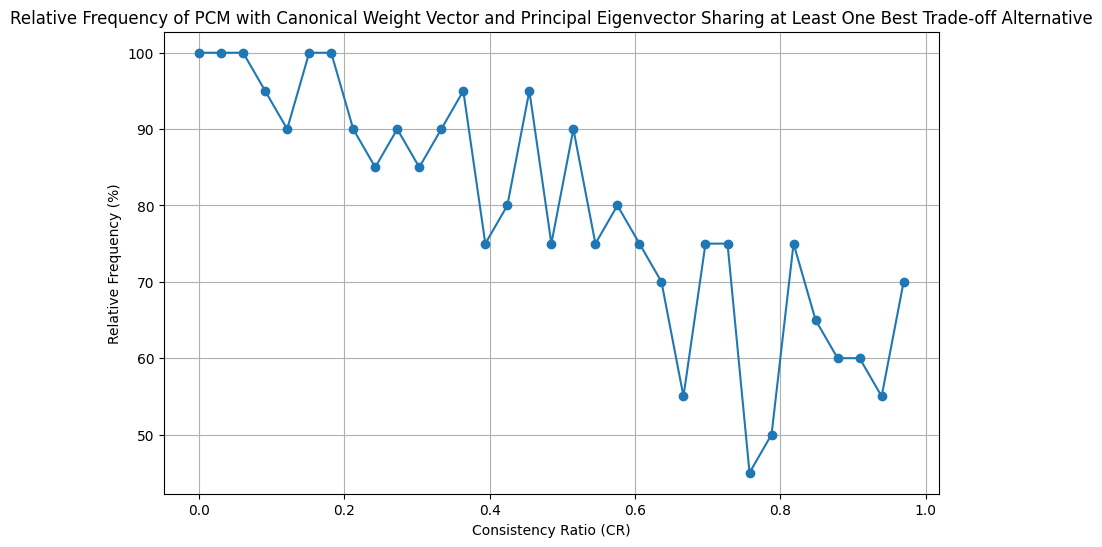

In [47]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

def analyze_matrices(matrices):
    """
    Analyzes each matrix in each CR interval, calculating A2w and Kappa,
    then checks if their maximum indices match.

    Parameters:
    matrices (dict): A dictionary where keys are CR intervals, and values are lists of PCM matrices.

    Returns:
    dict: A dictionary with CR intervals as keys and counts of matching max indices as values.
    """
    match_counts = defaultdict(int)
    total_counts = defaultdict(int)

    for cr_interval, matrix_list in matrices.items():
        for matrix in matrix_list:
            # Calculate A2w and Kappa vectors
            a2w_vector = A2w(matrix)
            kappa_vector =  np.round(m_tilde_cdd(np.log(matrix)),5)

            # Find index of the maximum element in each vector, there may be
            # more maximum elements in kappa_vector
            # Check if the indices match and record the result
            if np.argmax(a2w_vector) in [i for i, v in enumerate(kappa_vector) if v == max(kappa_vector)]:
                match_counts[cr_interval] += 1
            total_counts[cr_interval] += 1

    # Calculate success rate for each CR interval
    success_rate = {cr: match_counts[cr] / total_counts[cr] for cr in match_counts}
    return success_rate

def plot_success_rate(success_rate):
    """
    Plots the success rate (matching max indices) as a function of Consistency Ratio (CR).

    Parameters:
    success_rate (dict): Dictionary where keys are CR intervals and values are success rates.
    """
    cr_values = sorted(success_rate.keys())
    match_percentages = [success_rate[cr] * 100 for cr in cr_values]  # Percentualní hodnocení

    plt.figure(figsize=(10, 6))
    plt.plot(cr_values, match_percentages, marker='o')
    plt.xlabel("Consistency Ratio (CR)")
    plt.ylabel("Relative Frequency (%)")
    plt.title("Relative Frequency of PCM with Canonical Weight Vector and " +
     "Principal Eigenvector Sharing at Least One " +
     "Best Trade-off Alternative")
    plt.grid(True)
    plt.show()

# create a dictionay of matrices with various CR
matrices = collect_pcm_matrices_for_cr_intervals(5, 33, 20)

# analyze and plot the success rate
success_rate = analyze_matrices(matrices)

# Plot the success rate
plot_success_rate(success_rate)